In [25]:
import pandas as pd
import numpy as np
from CausalInference import perform_causal_inference, summarize_refutations, plot_causal_effects
from data_preprocess import load_config, get_research_topic_data

import warnings
warnings.filterwarnings('ignore')

In [26]:
def process_interest_rates():
    # Load data
    dgs2 = pd.read_csv('Data/DGS2.csv')
    dgs10 = pd.read_csv('Data/DGS10.csv')
    
    # Process interest rates
    interest_rates = pd.merge(dgs2, dgs10, on='DATE')
    interest_rates['DATE'] = pd.to_datetime(interest_rates['DATE'])
    interest_rates = interest_rates.replace('.', np.nan).astype({'DGS2': float, 'DGS10': float}).ffill()
    interest_rates['is_yield_curve_inverted'] = (interest_rates['DGS10'] - interest_rates['DGS2']) < 0
    interest_rates.rename(columns={'DATE': 'date'}, inplace=True)
    
    interest_rates_monthly = interest_rates.resample('BM', on='date').agg({
        'is_yield_curve_inverted': lambda x: x.any(),
        'DGS2': 'mean',
        'DGS10': 'mean'
    }).reset_index()
    
    return interest_rates_monthly


def process_vix_data():
    # Load data
    vix = pd.read_csv('Data/vix.csv')
    
    # Lower the case of column names
    vix.columns = vix.columns.str.lower()
    
    # Convert the date column to datetime
    vix['date'] = pd.to_datetime(vix['date'])
    vix['daily_return'] = vix['close'].pct_change()
    vix['vix_spike'] = vix['close'] > vix['close'].rolling(window=60).quantile(0.95)
    
    # Set the 'date' as the index for resampling
    vix.set_index('date', inplace=True)
    
    # Resample to monthly frequency, calculating median and percentiles
    vix_monthly = vix.resample('BM').agg({
        'close': [lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)],
        'vix_spike': 'sum'       # Count how many spike days in the month
    }).reset_index()

    # Flatten the column names
    vix_monthly.columns = ['date', 'vix_25th_percentile', 'vix_75th_percentile', 
                           'vix_spike_days']
    
    # Additional monthly metrics
    vix_monthly['vix_range'] = vix_monthly['vix_75th_percentile'] - vix_monthly['vix_25th_percentile']
    
    # Panic condition: If the current month's close exceeds previous year's VIX values
    # Determine if panic happened on a daily basis
    vix['daily_panic'] = vix['close'] > 30

    # Aggregate daily panic to monthly (check if at least one panic day occurred in the month)
    vix_monthly_panic = vix['daily_panic'].resample('BM').max().reset_index()
    vix_monthly_panic.columns = ['date', 'was_market_panic']

    # Merge the monthly panic with vix_monthly
    vix_monthly = pd.merge(vix_monthly, vix_monthly_panic, on='date', how='left')
    
    return vix_monthly


def process_bank_sector_data():
    bank_sector = pd.read_csv('Data/BankSector_ohlcv.csv')

    # Process bank sector data
    bank_sector['date'] = pd.to_datetime(bank_sector['date'])

    # Calculate daily price-volume product (for VWAP calculation)
    bank_sector['price_volume'] = bank_sector['close'] * bank_sector['volume']

    # Set the 'date' as the index for resampling
    bank_sector.set_index('date', inplace=True)

    # Group by both 'ticker' and resample by 'month'
    bank_sector_monthly = bank_sector.groupby('ticker').resample('BM').agg({
        'close': 'last',       # Last closing price of the month
        'price_volume': 'sum',  # Sum of price*volume for the month
        'volume': 'sum'         # Total volume for VWAP calculation
    }).reset_index()

    # Calculate the VWAP for the month
    bank_sector_monthly['vwap'] = bank_sector_monthly['price_volume'] / bank_sector_monthly['volume']
    bank_sector_monthly.drop(columns=['price_volume'], inplace=True)
    bank_sector_monthly = ticker2country(bank_sector_monthly)
    return bank_sector_monthly

def ticker2country(df):
    # Define the mapping of tickers to countries
    ticker_country_mapping = {
        "JPM": "United States",
        "BAC": "United States",
        "WFC": "United States",
        "RY": "Canada",
        "HDB": "India",
        "MS": "United States",
        "HSBC": "United Kingdom",
        "GS": "United States",
        "MUFG": "Japan",
        "SCHW": "United States",
        "C": "United States",
        "TD": "Canada",
        "IBN": "India",
        "UBS": "Switzerland",
        "SMFG": "Japan",
        "BNPQY": "France",
        "SAN": "Spain",
        "PNC": "United States",
        "USB": "United States",
        "NU": "Brazil",
        "BNS": "Canada",
        "BMO": "Canada",
        "BBVA": "Spain",
        "ITUB": "Brazil",
        "ING": "Netherlands",
        "TFC": "United States",
        "IBKR": "United States",
        "BK": "United States",
        "BCS": "United Kingdom",
        "BSBR": "Brazil",
        "DB": "Germany",
    }

    df['is_UnitedStates'] = (df['ticker'].map(ticker_country_mapping) == 'United States').astype(int)
    return df

def prepare_data():
    # Load and process datasets
    interest_rates_monthly = process_interest_rates()
    bank_sector_monthly = process_bank_sector_data()
    vix_monthly = process_vix_data()

    monthly_data = pd.merge(
        bank_sector_monthly, 
        vix_monthly, 
        on='date', 
        how='left' # different dates in vix and bank sector
    )
    # Merge with interest rates
    monthly_data = pd.merge(
        monthly_data, 
        interest_rates_monthly, 
        on='date', 
        how='left'
    )

    
    # Feature engineering on monthly data
    monthly_data['month_return'] = monthly_data.groupby('ticker')['close'].pct_change()
    
    # Calculate moving averages
    monthly_data['MA3'] = monthly_data.groupby('ticker')['close'].rolling(window=3).mean().reset_index(0, drop=True)
    monthly_data['MA6'] = monthly_data.groupby('ticker')['close'].rolling(window=6).mean().reset_index(0, drop=True)
    monthly_data['MA12'] = monthly_data.groupby('ticker')['close'].rolling(window=12).mean().reset_index(0, drop=True)
    
    # Identify bulge bracket banks
    bulge_bracket_banks = ['JPM', 'BAC', 'C', 'GS', 'MS', 'DB', 'UBS', 'BCS']
    monthly_data['is_bulge_brackets'] = monthly_data['ticker'].isin(bulge_bracket_banks).astype(int)
    
    # Create month dummies
    monthly_data['month'] = monthly_data['date'].dt.month
    month_names = [
        'January', 'February', 'March', 'April', 'May', 'June', 
        'July', 'August', 'September', 'October', 'November', 'December'
    ]
    for month, month_name in enumerate(month_names, start=1):
        monthly_data[month_name] = (monthly_data['month'] == month).astype(int)
    
    # Clean and sort data
    monthly_data = monthly_data.dropna()
    monthly_data = monthly_data.sort_values('date')
    return monthly_data

In [27]:
# Prepare data
df = prepare_data()

In [28]:
df

,ticker,date,close,volume,vwap,is_UnitedStates,vix_25th_percentile,vix_75th_percentile,vix_spike_days,vix_range,...,March,April,May,June,July,August,September,October,November,December
11,BAC,2000-12-29,45.88,145382400,42.264120,1,24.962500,27.720001,2,2.757501,...,0,0,0,0,0,0,0,0,0,1
7121,TD,2000-12-29,29.00,2680300,27.644414,0,24.962500,27.720001,2,2.757501,...,0,0,0,0,0,0,0,0,0,1
6599,SCHW,2000-12-29,28.38,92144700,29.246825,1,24.962500,27.720001,2,2.757501,...,0,0,0,0,0,0,0,0,0,1
6302,SAN,2000-12-29,10.56,3835200,9.575071,0,24.962500,27.720001,2,2.757501,...,0,0,0,0,0,0,0,0,0,1
6005,RY,2000-12-29,33.88,2518000,31.474453,0,24.962500,27.720001,2,2.757501,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4514,ING,2024-09-30,18.66,19386179,18.058437,0,17.139999,19.900000,0,2.760000,...,0,0,0,0,0,0,1,0,0,0
5083,JPM,2024-09-30,211.09,159418090,210.208697,1,17.139999,19.900000,0,2.760000,...,0,0,0,0,0,0,1,0,0,0
593,BBVA,2024-09-30,10.86,21308627,10.260090,0,17.139999,19.900000,0,2.760000,...,0,0,0,0,0,0,1,0,0,0
3713,HSBC,2024-09-30,44.17,19700441,43.563057,0,17.139999,19.900000,0,2.760000,...,0,0,0,0,0,0,1,0,0,0


In [29]:
df.columns


Index(['ticker', 'date', 'close', 'volume', 'vwap', 'is_UnitedStates',
       'vix_25th_percentile', 'vix_75th_percentile', 'vix_spike_days',
       'vix_range', 'was_market_panic', 'is_yield_curve_inverted', 'DGS2',
       'DGS10', 'month_return', 'MA3', 'MA6', 'MA12', 'is_bulge_brackets',
       'month', 'January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August', 'September', 'October', 'November', 'December'],
      dtype='object')

In [30]:
# Load configuration and get research topic data
config = load_config('config.yaml')
research_topic = 'month_effect'
treatments, common_causes, outcome = get_research_topic_data(config, research_topic)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(E[month_return|DGS2,vwap,vix_spike_days,is_yield_curve_inverted,was_m
d[April]                                                                      

                                                                            
arket_panic,is_bulge_brackets,DGS10,MA6,vix_range,MA3,is_UnitedStates,MA12])
                                                                            
Estimand assumption 1, Unconfoundedness: If U→{April} and U→month_return then P(month_return|April,DGS2,vwap,vix_spike_days,is_yield_curve_inverted,was_market_panic,is_bulge_brackets,DGS10,MA6,vix_range,MA3,is_UnitedStates,MA12,U) = P(month_return|April,DGS2,vwap,vix_spike_days,is_yield_curve_inverted,was_market_panic,is_bulge_brackets,DGS10,MA6,vix_range,MA3,is_UnitedSta

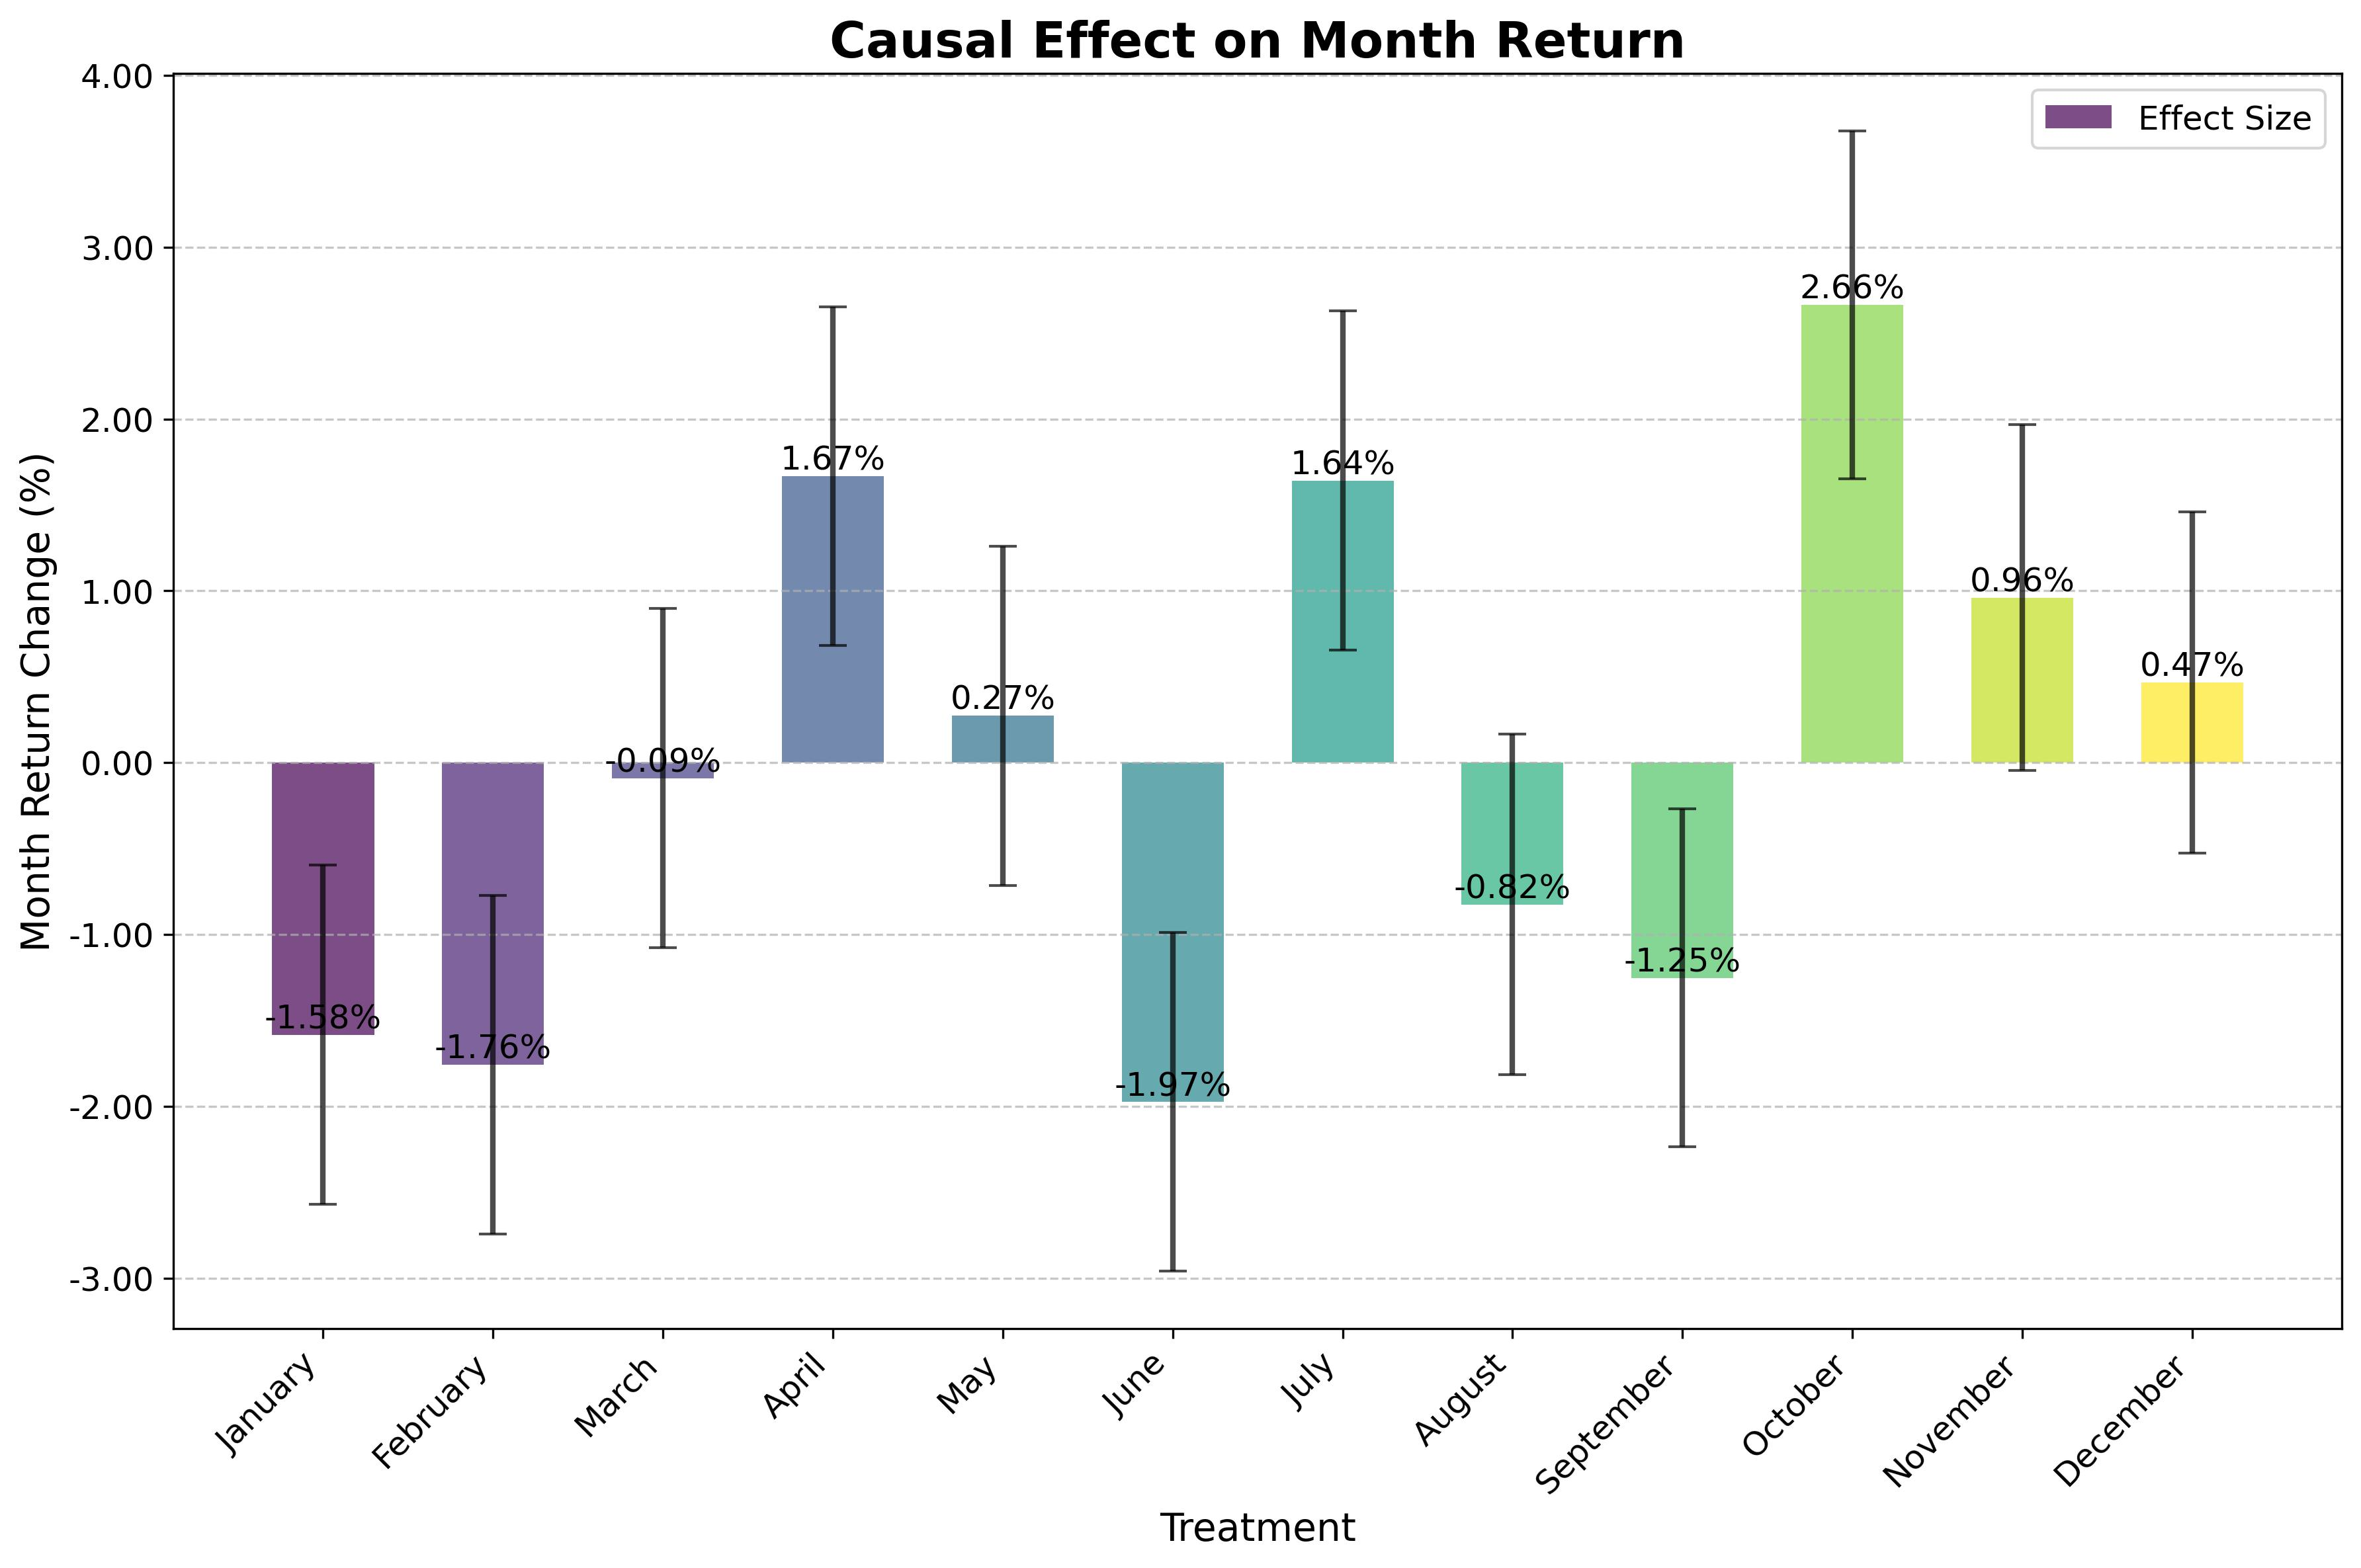

In [31]:


# Perform causal inference
results, refutations = perform_causal_inference(df, treatments, outcome, common_causes)

# Summarize refutations
output_dir = config['research_topics'][research_topic]['output_directory']
refutation_summary, interpretation = summarize_refutations(refutations, output_dir)

# Plot causal effects
plot_causal_effects(results, treatments, config, research_topic)

# Print results
print("Causal Inference Results for Month Effect:")
for treatment, estimate in results.items():
    print(f"{treatment}: {estimate.value:.4f} (95% CI: {estimate.get_confidence_intervals()[0]})")

# Display the plot
from IPython.display import Image
Image(filename=f'{output_dir}/{research_topic}.jpg')
